In [1]:
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG16,VGG19
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPool2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

In [2]:
input_path = "btData/"
train_path = input_path +"Train/"
test_path = input_path +"Test/"
val_path = input_path +"Val/"

batch_size=40

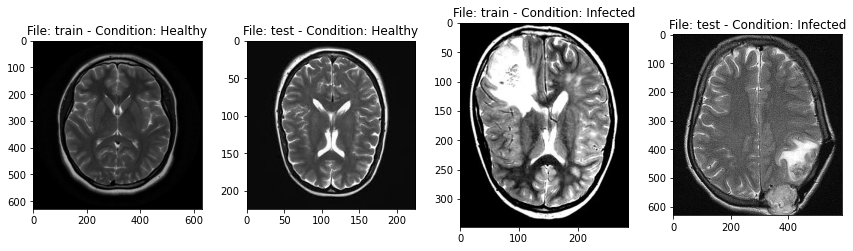

In [3]:
fig, ax = plt.subplots(1,4, figsize=(12,12))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/no/'+os.listdir(set_path+'/no')[0]),cmap='gray')
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/yes/'+os.listdir(set_path+'/yes')[0]),cmap='gray')
    ax[i+2].set_title('File: {} - Condition: Infected'.format(_set))

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                rotation_range=30,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

Found 2349 images belonging to 2 classes.
Found 511 images belonging to 2 classes.


In [5]:
model = Sequential()
model.add(Conv2D(input_shape=(256, 256, 3), filters=32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate=0.0001,decay=1e-5),
              metrics=['acc'])

In [7]:
history = model.fit(
train_generator,
steps_per_epoch=train_generator.samples//batch_size,
epochs=50,
validation_data=validation_generator,
validation_steps=validation_generator.samples//batch_size
)

Epoch 1/50
58/58 [==============================] - 79s 1s/step - loss: 0.5762 - acc: 0.6983 - val_loss: 0.5243 - val_acc: 0.7458
Epoch 2/50
58/58 [==============================] - 79s 1s/step - loss: 0.4927 - acc: 0.7641 - val_loss: 0.4823 - val_acc: 0.7750
Epoch 3/50
58/58 [==============================] - 80s 1s/step - loss: 0.4421 - acc: 0.7802 - val_loss: 0.7086 - val_acc: 0.6458
Epoch 4/50
58/58 [==============================] - 79s 1s/step - loss: 0.4271 - acc: 0.7972 - val_loss: 0.4787 - val_acc: 0.8000
Epoch 5/50
58/58 [==============================] - 80s 1s/step - loss: 0.3784 - acc: 0.8310 - val_loss: 0.5929 - val_acc: 0.7208
Epoch 6/50
58/58 [==============================] - 79s 1s/step - loss: 0.3679 - acc: 0.8303 - val_loss: 0.4679 - val_acc: 0.7958
Epoch 7/50
58/58 [==============================] - 79s 1s/step - loss: 0.3275 - acc: 0.8552 - val_loss: 0.4632 - val_acc: 0.8042
Epoch 8/50
58/58 [==============================] - 79s 1s/step - loss: 0.3391 - acc: 0.84

<function matplotlib.pyplot.show(close=None, block=None)>

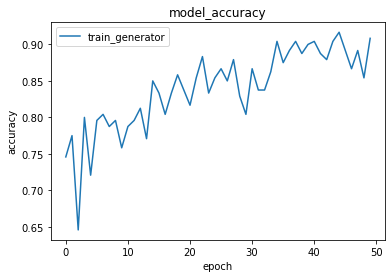

In [8]:
plt.plot(history.history['val_acc'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_generator','validation_generator'], loc='upper left')
plt.show

In [9]:
model.save("cnn-tumor-0.9083.h5")

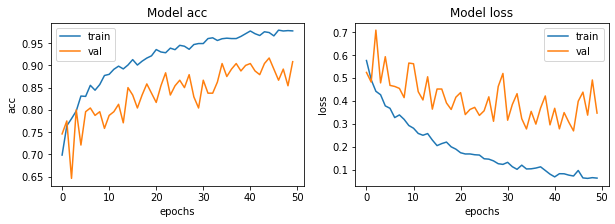

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val']) 